## ***SEMI-SUPERVISED LEARNING : CO-TRAINING***

In [75]:
import pandas as pd
import numpy as np
import seaborn as sns

In [76]:
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

In [77]:
df = pd.read_csv("datasets/cleaned_online_sex_work.csv")
df.head()

,User_ID,Female,Age,Location,Verification,Heterosexual,Homosexual,bicurious,bisexual,Dominant,...,Member_since_month,Member_since_day,Number_of_Comments_in_public_forum,Time_spent_chating_H:M,Number_of_advertisments_posted,Number_of_offline_meetings_attended,Number of Friends,Profile_pictures,Friends_ID_list,Risk
0,10386,False,34.6,A,False,0,1,0,0,0,...,9,17,32,2,0,0,1,0,18260,0.0
1,14,False,32.2,J,False,1,0,0,0,1,...,11,1,710,225,9,0,7,0,"11778,32024,43768,23969,27318,45884,31277",0.0
2,16721,False,33.6,K,False,1,0,0,0,1,...,4,1,25,135,1,1,3,45,"19805,21721,19802",0.0
3,16957,False,34.0,H,False,1,0,0,0,1,...,4,8,107,21562,1,0,12,1,"40847,38183,9507,42259,5807,28118,24848,37170,...",0.0
4,17125,False,39.5,B,False,1,0,0,0,1,...,4,14,600,21,0,6,35,8,"1320,35739,34231,19097,20197,18069,12330,43342...",0.0


In [78]:
df.isna().sum()

User_ID                                    0
Female                                     0
Age                                        0
Location                                   0
Verification                               0
Heterosexual                               0
Homosexual                                 0
bicurious                                  0
bisexual                                   0
Dominant                                   0
Submisive                                  0
Switch                                     0
Men                                        0
Men_and_Women                              0
Nobody                                     0
Nobody_but_maybe                           0
Women                                      0
Points_Rank                                0
Last_login                                 0
Member_since_year                          0
Member_since_month                         0
Member_since_day                           0
Number_of_

## Doing the same pre-processing as self-training

In [79]:
truth_map = {True: 1, False: 0}

df['Female'] = df['Female'].map(truth_map)
df['Verification'] = df['Verification'].map(truth_map)


In [80]:
#too many categories, so we take the top 10 and make dummies
top_10 = df['Location'].value_counts().head(10).index.to_list()

def dummies(d, var, top10):
    for label in top10:
        d[var+'_'+label] = np.where(df[var] == label, 1, 0)

dummies(df, 'Location', top_10)
df.drop('Location', axis = 1, inplace = True)

In [81]:
def transform_id_list(x):
    if (isinstance(x, str)):
        return len(x.split(','))
    else:
        return 0;

df['Friends'] = df['Friends_ID_list'].apply(lambda x: transform_id_list(x))
df = df.drop('Friends_ID_list', axis = 1)

In [82]:
df.drop('User_ID', axis = 1, inplace=True)

In [83]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28831 entries, 0 to 28830
Data columns (total 38 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Female                               28831 non-null  int64  
 1   Age                                  28831 non-null  float64
 2   Verification                         28831 non-null  int64  
 3   Heterosexual                         28831 non-null  int64  
 4   Homosexual                           28831 non-null  int64  
 5   bicurious                            28831 non-null  int64  
 6   bisexual                             28831 non-null  int64  
 7   Dominant                             28831 non-null  int64  
 8   Submisive                            28831 non-null  int64  
 9   Switch                               28831 non-null  int64  
 10  Men                                  28831 non-null  int64  
 11  Men_and_Women               

In [84]:
#Original dataset which contains information about the features

original_df = pd.read_csv('datasets/online_sex_work.csv')

In [85]:
original_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 18 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   User_ID                              28831 non-null  float64
 1   Gender                               28827 non-null  object 
 2   Age                                  28831 non-null  object 
 3   Location                             28830 non-null  object 
 4   Verification                         28831 non-null  object 
 5   Sexual_orientation                   28830 non-null  object 
 6   Sexual_polarity                      28830 non-null  object 
 7   Looking_for                          28406 non-null  object 
 8   Points_Rank                          28831 non-null  object 
 9   Last_login                           28831 non-null  object 
 10  Member_since                         28831 non-null  object 
 11  Number_of_Comments_in_pu

In [86]:
original_df['Gender'].value_counts()

male      22382
female     6445
Name: Gender, dtype: int64

In [87]:
original_df['Sexual_orientation'].value_counts()

Heterosexual    20441
bisexual         4391
bicurious        2992
Homosexual       1006
Name: Sexual_orientation, dtype: int64

In [88]:
original_df['Looking_for'].value_counts()

Nobody              19928
Women                4896
Nobody_but_maybe     1512
Men_and_Women        1074
Men                   996
Name: Looking_for, dtype: int64

### Co-learning

#### We have to split the features into mutually independent views, train 2 classifiers each for one view

<AxesSubplot:>

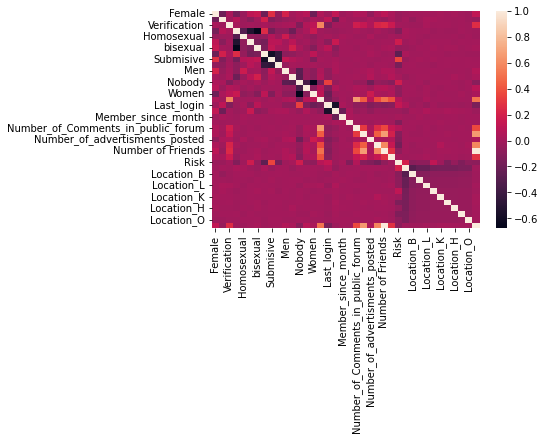

In [89]:
sns.heatmap(df.corr())

In [90]:
view1 = df[['Female', 
            'Dominant', 'Submisive', 'Switch', 
            'Verification', 
            'Nobody', 'Men', 'Men_and_Women', 'Women', 'Nobody_but_maybe', 
            'Points_Rank', 'Last_login', 'Member_since_year', 'Member_since_month', 'Member_since_day',
            'Number_of_Comments_in_public_forum',
            'Number_of_advertisments_posted',
            'Profile_pictures',
            'Risk']]

In [91]:
view2 = df[['Heterosexual', 'Homosexual', 'bicurious', 'bisexual', 
            'Age', 
            'Location_A', 'Location_B', 'Location_C', 'Location_G', 'Location_L', 
            'Location_O', 'Location_E', 'Location_H', 'Location_K', 'Location_M',
            'Time_spent_chating_H:M',
            'Number_of_offline_meetings_attended',
            'Friends',
            'Risk']]

In [92]:
view1.shape

(28831, 19)

In [93]:
view2.shape

(28831, 19)

In [94]:
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import TensorBoard
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ParameterGrid
from tensorflow.keras.losses import BinaryCrossentropy

In [95]:
def calc_loss(actual, predicted):
    bce = BinaryCrossentropy(from_logits=True)
    return bce(actual, predicted).numpy()

In [96]:
param_grid = ParameterGrid(
    {
        'hidden_layers': list(range(11)),
        'neurons': [10,20,30,40,50],
        'activation': ['relu', 'tanh', 'swish']
    }
)

In [97]:
def create_model(params):
    model = Sequential()
    model.add(Flatten())
    model.add(Dense(18, activation='relu'))
    for i in range(params['hidden_layers']):
        model.add(Dense(params['neurons'], activation=params['activation']))
        model.add(Dropout(0.2))
    model.add(Dense(1, activation = 'sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [98]:
#function to tune the model

def tune_hyperparameters(param_grid, X_train, y_train):
    parameters = pd.DataFrame(columns=["log_loss", "params"])
    for parameter_set in param_grid:
        model = create_model(parameter_set)
        model.fit(X_train, y_train, epochs = 50, verbose=0)
        preds = model.predict(X_train, verbose=0)
        loss = calc_loss(y_train, preds)
        parameters = pd.concat([pd.DataFrame({"log_loss":loss, "params": parameter_set}), parameters], axis=0)
    # parameters = parameters.sort_values("log_loss").reset_index().iloc[0]
    min_loss = parameters['log_loss'].sort_values(ascending=False)[0]
    best_params = parameters[parameters['log_loss'] == min_loss]
    return {
    'activation': best_params.loc['activation']['params'],
    'hidden_layers': best_params.loc['hidden_layers']['params'],
    'neurons': best_params.loc['neurons']['params']
    }   
    

In [99]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=1)

In [100]:
#gets pseudo-labels based on partially-trained model

def get_pseudo_labels(model, unlabelled_df):
    return model.predict(unlabelled_df)

In [101]:
# filters prediction based on how confident the model is in predicting the output

def get_confident_labels(confidence_level, pseudolabels):
    confident_labels = []
    for i in pseudolabels:
        value = i[0]
        if value >= confidence_level:
            confident_labels.append([value, 1])
        elif value <= 1-confidence_level:
            confident_labels.append([value, 1])
        else:
            confident_labels.append([value, 0])
    return pd.DataFrame(confident_labels, columns=["Risk", "confident"])


## Co-training

In [102]:
v1_u = view1[view1['Risk'].isna()]
v1_l = view1.dropna()
v2_u = view2[view2['Risk'].isna()]
v2_l = view2.dropna()

In [104]:
def scaled_splits(df):
    X = df.drop(['Risk'], axis =1)
    y = df['Risk'].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    y_train = y_train.reshape(y_train.shape[0], 1)
    return X_train, X_test, y_train, y_test

In [105]:
def co_training(view1_labelled, view1_unlabelled,
                view2_labelled, view2_unlabelled, 
                confidence_level = 1.00):

    if len(view1_unlabelled) > 0 and len(view2_unlabelled) > 0:
        labelled_X1_train, labelled_X1_test, labelled_y1_train, labelled_y1_test = scaled_splits(view1_labelled)
        params1 = tune_hyperparameters(param_grid, labelled_X1_train, labelled_y1_train)
        model1 = create_model(params1)
        model1.fit(labelled_X1_train, labelled_y1_train, epochs =50, validation_data = [labelled_X1_test, labelled_y1_test], callbacks = [early_stop])
        pd.DataFrame(model1.history.history).plot()
        pseudolabels1 = get_pseudo_labels(model1, view1_unlabelled.drop('Risk', axis = 1))
        confident_labels_df1 = get_confident_labels(confidence_level, pseudolabels1)

        labelled_X2_train, labelled_X2_test, labelled_y2_train, labelled_y2_test = scaled_splits(view2_labelled)
        params2 = tune_hyperparameters(param_grid, labelled_X2_train, labelled_y2_train)
        model2 = create_model(params2)
        model2.fit(labelled_X2_train, labelled_y2_train, epochs =50, validation_data = [labelled_X2_test, labelled_y2_test], callbacks = [early_stop])
        pd.DataFrame(model2.history.history).plot()
        pseudolabels2 = get_pseudo_labels(model2, view2_unlabelled.drop('Risk', axis = 1))
        confident_labels_df2 = get_confident_labels(confidence_level, pseudolabels2)

        mid_view1 = pd.concat([view1_unlabelled.drop('Risk', axis = 1).reset_index(), confident_labels_df2.reset_index()], axis = 1)
        mid_view2 = pd.concat([view2_unlabelled.drop('Risk', axis = 1).reset_index(), confident_labels_df1.reset_index()], axis = 1)

        new_view1_labelled = mid_view1[mid_view1['confident'] == 1]
        new_view1_unlabelled = mid_view1[mid_view1['confident'] == 0]

        new_view2_labelled = mid_view2[mid_view2['confident'] == 1]
        new_view2_unlabelled = mid_view2[mid_view2['confident'] == 0]

        return new_view1_labelled.drop('index', axis = 1), new_view1_unlabelled.drop('index', axis = 1), new_view2_labelled.drop('index', axis = 1), new_view2_unlabelled.drop('index', axis = 1)

Epoch 1/50
3/3 [==============================] - 2s 135ms/step - loss: 0.6921 - accuracy: 0.6111 - val_loss: 0.6894 - val_accuracy: 0.7222
Epoch 2/50
3/3 [==============================] - 0s 14ms/step - loss: 0.6895 - accuracy: 0.6111 - val_loss: 0.6859 - val_accuracy: 0.7222
Epoch 3/50
3/3 [==============================] - 0s 20ms/step - loss: 0.6854 - accuracy: 0.5972 - val_loss: 0.6824 - val_accuracy: 0.7222
Epoch 4/50
3/3 [==============================] - 0s 18ms/step - loss: 0.6838 - accuracy: 0.6111 - val_loss: 0.6784 - val_accuracy: 0.7222
Epoch 5/50
3/3 [==============================] - 0s 17ms/step - loss: 0.6813 - accuracy: 0.6111 - val_loss: 0.6743 - val_accuracy: 0.7222
Epoch 6/50
3/3 [==============================] - 0s 23ms/step - loss: 0.6835 - accuracy: 0.6111 - val_loss: 0.6705 - val_accuracy: 0.7222
Epoch 7/50
3/3 [==============================] - 0s 20ms/step - loss: 0.6783 - accuracy: 0.6111 - val_loss: 0.6667 - val_accuracy: 0.7222
Epoch 8/50
3/3 [==========

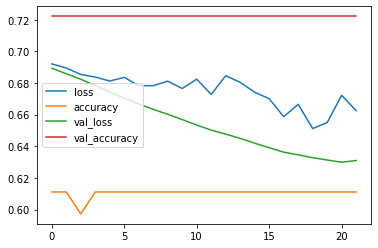

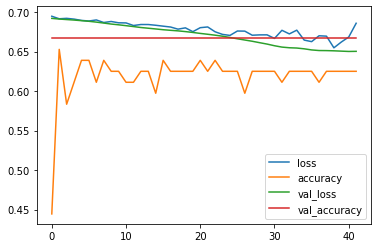

In [107]:
out = co_training(v1_l, v1_u, v2_l, v2_u, 1.00)

In [ ]:
out[0]

,Female,Dominant,Submisive,Switch,Verification,Nobody,Men,Men_and_Women,Women,Nobody_but_maybe,Points_Rank,Last_login,Member_since_year,Member_since_month,Member_since_day,Number_of_Comments_in_public_forum,Number_of_advertisments_posted,Profile_pictures,Risk,confident
22,0,0,0,1,0,0,0,0,0,1,10,22,2012,9,6,10,0,0,0.0,1
24,0,1,0,0,0,0,0,0,1,0,18,308,2012,9,6,4,1,0,0.0,1
25,0,1,0,0,0,0,0,0,1,0,0,3,2012,9,6,0,0,0,0.0,1
57,1,0,1,0,1,0,0,0,0,1,115,17,2012,9,7,0,0,0,0.0,1
74,1,0,0,1,0,1,0,0,0,0,34,353,2012,9,8,4,0,0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28653,0,0,1,0,0,0,0,0,1,0,15,315,2012,9,2,0,0,0,0.0,1
28686,1,0,0,1,0,1,0,0,0,0,369,197,2012,9,3,466,0,1,0.0,1
28702,0,1,0,0,0,1,0,0,0,0,24,39,2012,9,4,31,0,0,0.0,1
28704,1,0,1,0,0,1,0,0,0,0,10,1517,2012,9,4,0,0,3,0.0,1


In [ ]:
out[1]

,Female,Dominant,Submisive,Switch,Verification,Nobody,Men,Men_and_Women,Women,Nobody_but_maybe,Points_Rank,Last_login,Member_since_year,Member_since_month,Member_since_day,Number_of_Comments_in_public_forum,Number_of_advertisments_posted,Profile_pictures,Risk,confident
0,0,1,0,0,0,1,0,0,0,0,0,1671,2012,9,6,0,0,0,8.025781e-03,0
1,0,1,0,0,0,1,0,0,0,0,0,1696,2012,9,6,0,0,0,4.503042e-03,0
2,0,1,0,0,0,0,0,0,0,1,0,49,2012,9,6,0,0,0,2.466951e-02,0
3,1,0,0,1,0,1,0,0,0,0,0,1696,2012,9,6,0,0,0,6.195696e-02,0
4,0,1,0,0,0,1,0,0,0,0,0,1696,2012,9,6,0,0,0,1.656792e-03,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28736,0,0,0,1,0,0,0,0,1,0,0,23,2012,9,5,0,1,0,6.054061e-02,0
28737,0,0,1,0,0,0,0,1,0,0,15,597,2012,9,5,0,0,0,4.557333e-03,0
28738,0,0,1,0,0,0,0,0,1,0,15,4,2012,9,5,0,0,0,6.747166e-02,0
28739,0,0,1,0,0,0,1,0,0,0,30,665,2012,9,1,0,4,0,5.996788e-14,0


In [ ]:
out[2]

,Heterosexual,Homosexual,bicurious,bisexual,Age,Location_A,Location_B,Location_C,Location_G,Location_L,Location_O,Location_E,Location_H,Location_K,Location_M,Time_spent_chating_H:M,Number_of_offline_meetings_attended,Friends,Risk,confident
0,1,0,0,0,42.9,1,0,0,0,0,0,0,0,0,0,0,0,0,0.0,1
1,1,0,0,0,47.4,0,1,0,0,0,0,0,0,0,0,0,0,0,0.0,1
2,1,0,0,0,35.2,0,0,0,0,0,0,0,0,0,0,1,0,0,0.0,1
3,1,0,0,0,28.6,0,1,0,0,0,0,0,0,0,0,0,0,0,0.0,1
4,1,0,0,0,56.6,0,0,0,0,1,0,0,0,0,0,0,0,0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28736,1,0,0,0,27.2,0,0,0,0,0,0,0,0,0,0,3,0,0,0.0,1
28737,0,0,1,0,46.4,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,1
28738,1,0,0,0,28.8,0,0,1,0,0,0,0,0,0,0,0,0,0,0.0,1
28739,0,0,0,1,31.5,0,0,0,0,0,0,0,0,0,0,174,0,0,0.0,1


In [ ]:
out[3]

,Heterosexual,Homosexual,bicurious,bisexual,Age,Location_A,Location_B,Location_C,Location_G,Location_L,Location_O,Location_E,Location_H,Location_K,Location_M,Time_spent_chating_H:M,Number_of_offline_meetings_attended,Friends,Risk,confident
